# Работа с базами данных. SQL Проект 4. Авиарейсы без потерь

Задача проекта;

1. Готовим один большой запрос, который нам позволяет выгрузить все необходимые данные для последующего анализа. Запрос обязательно должен содержать доход с продажи билетов по каждому рейсу, заполняемость каждого рейса (или кол-во проданных билетов), длительность рейса (или координаты населённых пунктов). Сохраняем данные в файле с расширением *.csv.
2. В блокноте юпитера загружаем наш сохранённый файл и анализируем его. Проводим EDA. Основное, что мы должны получить в результате анализа, так это установить малоприбыльные (убыточные рейсы). Обычно эти рейсы выделяются из общей группы ("хвост"). Для каждого направления достаточно указать 2-3 рейса. Критерием убыточности можно выбрать заполняемость самолёта на рейсе. Определим уровень безубыточности на уровне более 70-75%.
3. Всю полученную информацию в анализе мы можем использовать при подготовке презентации. Например, графики. В презентации обязательно раскрываем 4 обязательных пункта и добавляем выводы и рекомендации.
- Структуру датасета
- Описание данных
- Дополнительные данные
- Способы оценки
- Выводы
- Рекомендации
4. Запрос с решениями из 4 и 5 раздела добавляем в отдельный файл формата *.txt. Загружаем его на гитхаб. Дополнительно на гитхаб грузим датасет и блокнот юпитера, где проводился анализ. Презентацию загружаем на гугл-диск. Ссылки указываем в ответе на платформе. Если проводили анализ в блокноте юпитера, то не забываем указывать ответ на дополнительное задание.

Основное, что должен выводить запрос: длительность полёта (или координаты), заполняемость (кол-во проданных билетов) и доход с продажи билетов. Без этих данных прибыль не оценить. Всё остальное для поиска полезных закономерностей.

In [1]:
# Перечень признаков в финальной версии ISQ обработки:
#     flight_id,
#     f.flight_no,
#     f.scheduled_departure,
#     f.scheduled_arrival,
#     f.actual_departure,
#     f.actual_arrival,
#     table_1.scheduled_flytime - запланированое время полета в минутах
#     table_1.actual_flytime - актуальное время полета в минутах
#     table_1.flyminute_diff - информация о задержке либо прибытие раньше в минутах
#     f.departure_airport,
#     f.arrival_airport,
#     f.status,
#     table_3.model,
#     table_2.aircraft_code,
#     table_3.fuel_per_minute - расход топлива тонн в минуту
#     table_2.bought_seats - занятые места на самолете
#     table_2.total_seats - всего мест на самолете
#     table_2.occupied_seats - процент занятости мест на самолете
#     table_9.ticket_economy - количестве билетов по классам для экооном рейса
#     table_9.ticket_comfort - количестве билетов по классам для комфорт рейса
#     table_9.ticket_bisiness - количестве билетов по классам для бизнесс рейса
#     table_5.city,
#     table_5.airports_in_city - количество аэропортов в городе
#     table_5.airport_code,
#     table_7.airport_traffic - количество посадок+прибытий в аэропорту
#     table_7.share_of_traffic - доля количества посадок+прибытий в аэропорту от всех полетов в базе
#     table_6.booking_amount - сумма брони билета(ов)
#     table_6.ticket_price - цена билета
#     table_6.booking_income - разница между бронью и ценой билета
#     table_6.booking_perc - процент цены билета в брони билета
#     table_4.fuel_price - цена топлива за определенный месяцц
#     table_8.sum_ticket - сумма выручки билетов рейса

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок
pd.set_option('display.float_format', '{:.2f}'.format) # для корректного отображения больших чисел (Disable scientific notation )

In [3]:
#  Присваиваем название загруженого датасета
df = pd.read_csv('dataset.csv')

In [4]:
#  Функции используемые для анализа

def first_look(col, boundaries=None):
    print('Столбец', col)
    print('Распределение признака:')
    fig, ax = plt.subplots()
    # Проверка на строковый тип данных
    if df.loc[:, col].dtypes == np.dtype('O'):
        sns.countplot(df.loc[:, col], ax=ax)
        plt.show()
    else:

        df.loc[:, col].hist(ax=ax)
        ax.set_xlabel(col)
        ax.set_ylabel('count')
        plt.show()
        if boundaries is not None:  # Проверка на наличие выбросов по информации из датасета
            if df.loc[(~df.loc[:, col].between(boundaries[0], boundaries[1])) &
                        pd.notnull(df.loc[:, col])].shape[0] > 0:
                print('Найдены выбросы:')
                display(df.loc[(~df.loc[:, col]).between(boundaries[0], boundaries[1]) &
                                 pd.notnull(df.loc[:, col])])
        print('Процент пропусков:', str(
            round(100 - df.loc[:, col].count()/df.shape[0]*100, 2)) + '%')
        print()


# Функция для постройки Boxplot графиков
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='score',
                data=df,
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [5]:
# Рассмотрим, какие данные хранятся в файле и какие типы данных у столбцов:
display(df.head(10))
df.info()

,flight_id,flight_no,scheduled_departure,scheduled_arrival,actual_departure,actual_arrival,scheduled_flytime,actual_flytime,flyminute_diff,departure_airport,arrival_airport,status,model,aircraft_code,fuel_per_minute,total_seats,bought_seats,occupied_seats,ticket_economy,ticket_comfort,ticket_bisiness,city,airports_in_city,airport_traffic,share_of_traffic,booking_amount,ticket_price,booking_income,booking_perc,fuel_price,sum_ticket
0,136119,PG0252,2017-01-03T10:05:00Z,2017-01-03T11:45:00Z,2017-01-03T10:08:00Z,2017-01-03T11:49:00Z,100.00,101.00,1.00,AAQ,SVO,Arrived,Boeing 737-300,733,0.04,130.00,113.00,86.92,102.00,0.00,11.00,Moscow,3,38695,0.01,36400.00,12200.00,24200.00,66.48,41435.00,1653000.00
1,136119,PG0252,2017-01-03T10:05:00Z,2017-01-03T11:45:00Z,2017-01-03T10:08:00Z,2017-01-03T11:49:00Z,100.00,101.00,1.00,AAQ,SVO,Arrived,Boeing 737-300,733,0.04,130.00,113.00,86.92,102.00,0.00,11.00,Moscow,3,38695,0.01,24400.00,12200.00,12200.00,50.00,41435.00,1653000.00
2,136119,PG0252,2017-01-03T10:05:00Z,2017-01-03T11:45:00Z,2017-01-03T10:08:00Z,2017-01-03T11:49:00Z,100.00,101.00,1.00,AAQ,SVO,Arrived,Boeing 737-300,733,0.04,130.00,113.00,86.92,102.00,0.00,11.00,Moscow,3,38695,0.01,73200.00,12200.00,61000.00,83.33,41435.00,1653000.00
3,136119,PG0252,2017-01-03T10:05:00Z,2017-01-03T11:45:00Z,2017-01-03T10:08:00Z,2017-01-03T11:49:00Z,100.00,101.00,1.00,AAQ,SVO,Arrived,Boeing 737-300,733,0.04,130.00,113.00,86.92,102.00,0.00,11.00,Moscow,3,38695,0.01,24400.00,12200.00,12200.00,50.00,41435.00,1653000.00
4,136119,PG0252,2017-01-03T10:05:00Z,2017-01-03T11:45:00Z,2017-01-03T10:08:00Z,2017-01-03T11:49:00Z,100.00,101.00,1.00,AAQ,SVO,Arrived,Boeing 737-300,733,0.04,130.00,113.00,86.92,102.00,0.00,11.00,Moscow,3,38695,0.01,72800.00,12200.00,60600.00,83.24,41435.00,1653000.00
5,136119,PG0252,2017-01-03T10:05:00Z,2017-01-03T11:45:00Z,2017-01-03T10:08:00Z,2017-01-03T11:49:00Z,100.00,101.00,1.00,AAQ,SVO,Arrived,Boeing 737-300,733,0.04,130.00,113.00,86.92,102.00,0.00,11.00,Moscow,3,38695,0.01,60400.00,12200.00,48200.00,79.80,41435.00,1653000.00
6,136119,PG0252,2017-01-03T10:05:00Z,2017-01-03T11:45:00Z,2017-01-03T10:08:00Z,2017-01-03T11:49:00Z,100.00,101.00,1.00,AAQ,SVO,Arrived,Boeing 737-300,733,0.04,130.00,113.00,86.92,102.00,0.00,11.00,Moscow,3,38695,0.01,24400.00,12200.00,12200.00,50.00,41435.00,1653000.00
7,136119,PG0252,2017-01-03T10:05:00Z,2017-01-03T11:45:00Z,2017-01-03T10:08:00Z,2017-01-03T11:49:00Z,100.00,101.00,1.00,AAQ,SVO,Arrived,Boeing 737-300,733,0.04,130.00,113.00,86.92,102.00,0.00,11.00,Moscow,3,38695,0.01,84800.00,12200.00,72600.00,85.61,41435.00,1653000.00
8,136119,PG0252,2017-01-03T10:05:00Z,2017-01-03T11:45:00Z,2017-01-03T10:08:00Z,2017-01-03T11:49:00Z,100.00,101.00,1.00,AAQ,SVO,Arrived,Boeing 737-300,733,0.04,130.00,113.00,86.92,102.00,0.00,11.00,Moscow,3,38695,0.01,24400.00,12200.00,12200.00,50.00,41435.00,1653000.00
9,136119,PG0252,2017-01-03T10:05:00Z,2017-01-03T11:45:00Z,2017-01-03T10:08:00Z,2017-01-03T11:49:00Z,100.00,101.00,1.00,AAQ,SVO,Arrived,Boeing 737-300,733,0.04,130.00,113.00,86.92,102.00,0.00,11.00,Moscow,3,38695,0.01,97600.00,12200.00,85400.00,87.50,41435.00,1653000.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12004 entries, 0 to 12003
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   flight_id            12004 non-null  int64  
 1   flight_no            12004 non-null  object 
 2   scheduled_departure  12004 non-null  object 
 3   scheduled_arrival    12004 non-null  object 
 4   actual_departure     12004 non-null  object 
 5   actual_arrival       12004 non-null  object 
 6   scheduled_flytime    12004 non-null  float64
 7   actual_flytime       12004 non-null  float64
 8   flyminute_diff       12004 non-null  float64
 9   departure_airport    12004 non-null  object 
 10  arrival_airport      12004 non-null  object 
 11  status               12004 non-null  object 
 12  model                12004 non-null  object 
 13  aircraft_code        11995 non-null  object 
 14  fuel_per_minute      12004 non-null  float64
 15  total_seats          11995 non-null 

In [6]:
# Так как ticket_comfort содержит только нули - удалим его
df = df.drop('ticket_comfort', 1)

По поводу Новокузнецка - даные представленны с пропусками, что еще больше затрудняет анализ

In [7]:
# Доля пропусков в столбцах в %:
round(df.isna().sum()/12004*100, 1).nlargest(10)

aircraft_code     0.10
total_seats       0.10
bought_seats      0.10
occupied_seats    0.10
ticket_economy    0.10
ticket_bisiness   0.10
booking_amount    0.10
ticket_price      0.10
booking_income    0.10
booking_perc      0.10
dtype: float64

In [8]:
# создадим признак Расходы на топливо в каждом рейсе
df['fuel_cost'] = df['actual_flytime']*df['fuel_per_minute']

In [9]:
# создадим несколько признаков связанных с затратами топлива на одного пасажира
df['sched_fuel_per_pass'] = df['fuel_cost']/df['total_seats']
df['act_fuel_per_pass'] = df['fuel_cost']/df['occupied_seats']
df['diff_fuel_per_pass'] = df['sched_fuel_per_pass']-df['act_fuel_per_pass']

In [10]:
# создадим признак прибыли/убытка в каждом рейсе (если учитовать только расходы топлива)
df['income'] = df['sum_ticket']-df['fuel_cost']

In [11]:
# убыточных рейсов не обнаружено
df[df['income'] <= 0]

,flight_id,flight_no,scheduled_departure,scheduled_arrival,actual_departure,actual_arrival,scheduled_flytime,actual_flytime,flyminute_diff,departure_airport,arrival_airport,status,model,aircraft_code,fuel_per_minute,total_seats,bought_seats,occupied_seats,ticket_economy,ticket_bisiness,city,airports_in_city,airport_traffic,share_of_traffic,booking_amount,ticket_price,booking_income,booking_perc,fuel_price,sum_ticket,fuel_cost,sched_fuel_per_pass,act_fuel_per_pass,diff_fuel_per_pass,income


Столбец income
Распределение признака:


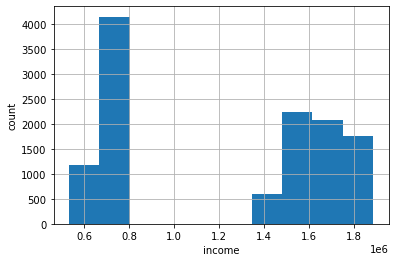

Процент пропусков: 0.07%



In [12]:
first_look('income')

# Дата и время

In [13]:
# приведем дату и время с формата object в формат datetime64
df['scheduled_departure'] = pd.to_datetime(df['scheduled_departure'])
df['scheduled_arrival'] = pd.to_datetime(df['scheduled_arrival'])
df['actual_departure'] = pd.to_datetime(df['actual_departure'])
df['actual_arrival'] = pd.to_datetime(df['actual_arrival'])

In [14]:
# приведем дату и время с формата datetime64 в формат integer
df['scheduled_departure'] = pd.to_numeric(df['scheduled_departure'].dt.strftime('%Y%m%d%H%M%S'))
df['scheduled_arrival'] = pd.to_numeric(df['scheduled_arrival'].dt.strftime('%Y%m%d%H%M%S'))
df['actual_departure'] = pd.to_numeric(df['actual_departure'].dt.strftime('%Y%m%d%H%M%S'))
df['actual_arrival'] = pd.to_numeric(df['actual_arrival'].dt.strftime('%Y%m%d%H%M%S'))

# Кореляция

In [15]:
df.corr()

,flight_id,scheduled_departure,scheduled_arrival,actual_departure,actual_arrival,scheduled_flytime,actual_flytime,flyminute_diff,fuel_per_minute,total_seats,bought_seats,occupied_seats,ticket_economy,ticket_bisiness,airports_in_city,airport_traffic,share_of_traffic,booking_amount,ticket_price,booking_income,booking_perc,fuel_price,sum_ticket,fuel_cost,sched_fuel_per_pass,act_fuel_per_pass,diff_fuel_per_pass,income
flight_id,1.00,0.02,0.02,0.02,0.02,-0.87,-0.87,0.16,-0.90,-0.90,-0.70,0.38,-0.73,0.17,-0.90,-0.90,-0.90,-0.10,-0.44,-0.00,0.36,-0.02,-0.87,-0.88,-0.90,-0.89,0.85,-0.87
scheduled_departure,0.02,1.00,1.00,1.00,1.00,-0.00,0.00,0.07,-0.00,-0.00,-0.04,-0.05,-0.03,-0.06,-0.00,-0.00,-0.00,-0.02,-0.00,-0.02,-0.01,-0.99,-0.02,0.00,0.00,0.01,-0.02,-0.02
scheduled_arrival,0.02,1.00,1.00,1.00,1.00,-0.00,0.00,0.07,-0.00,-0.00,-0.04,-0.05,-0.03,-0.06,-0.00,-0.00,-0.00,-0.02,-0.00,-0.02,-0.01,-0.99,-0.02,0.00,0.00,0.01,-0.02,-0.02
actual_departure,0.02,1.00,1.00,1.00,1.00,-0.00,0.00,0.07,-0.00,-0.00,-0.04,-0.05,-0.03,-0.06,-0.00,-0.00,-0.00,-0.02,-0.00,-0.02,-0.01,-0.99,-0.02,0.00,0.00,0.01,-0.02,-0.02
actual_arrival,0.02,1.00,1.00,1.00,1.00,-0.00,0.00,0.07,-0.00,-0.00,-0.04,-0.05,-0.03,-0.06,-0.00,-0.00,-0.00,-0.02,-0.00,-0.02,-0.01,-0.99,-0.02,0.00,0.00,0.01,-0.02,-0.02
scheduled_flytime,-0.87,-0.00,-0.00,-0.00,-0.00,1.00,1.00,-0.15,0.98,1.00,0.81,-0.39,0.84,-0.22,0.96,0.96,0.96,0.11,0.49,0.00,-0.41,0.00,0.97,1.00,1.00,0.98,-0.93,0.97
actual_flytime,-0.87,0.00,0.00,0.00,0.00,1.00,1.00,-0.12,0.97,1.00,0.80,-0.39,0.84,-0.22,0.96,0.96,0.96,0.11,0.48,0.00,-0.41,0.00,0.97,1.00,1.00,0.98,-0.93,0.97
flyminute_diff,0.16,0.07,0.07,0.07,0.07,-0.15,-0.12,1.00,-0.17,-0.17,-0.22,-0.03,-0.21,-0.18,-0.17,-0.17,-0.17,-0.04,-0.09,-0.02,0.06,-0.08,-0.22,-0.13,-0.14,-0.10,0.07,-0.22
fuel_per_minute,-0.90,-0.00,-0.00,-0.00,-0.00,0.98,0.97,-0.17,1.00,1.00,0.81,-0.39,0.84,-0.22,1.00,1.00,1.00,0.11,0.49,0.00,-0.41,0.00,0.97,0.98,1.00,0.98,-0.93,0.97
total_seats,-0.90,-0.00,-0.00,-0.00,-0.00,1.00,1.00,-0.17,1.00,1.00,0.81,-0.39,0.84,-0.22,1.00,1.00,1.00,0.11,0.49,0.00,-0.41,0.00,0.97,1.00,1.00,0.98,-0.93,0.97


In [16]:
# Увеличим дефолтный размер графиков
rcParams['figure.figsize'] = 15, 5

<AxesSubplot:>

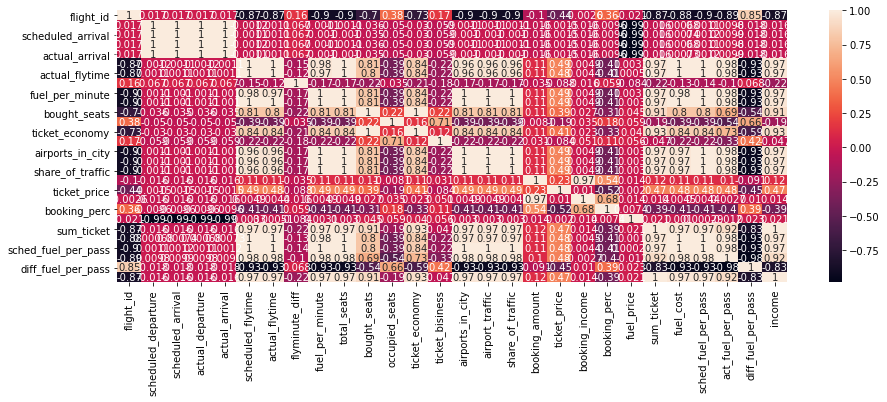

In [17]:
# Так как таблица корреляций трудно читаема, попробуем через график Heatmap
sns.heatmap(df.corr(), annot=True)

# Копия кода в SQL

In [18]:
# WITH table_1 AS (
# -- Информация о длительности полета по графику, актуальная длительность полета и задержка (прилёт раньше)
# select
#     a.flight_id,
#     EXTRACT(EPOCH FROM (a.scheduled_flytime)) / 60 scheduled_flytime,
#     EXTRACT(EPOCH FROM (a.actual_flytime)) / 60 actual_flytime,
#     EXTRACT(EPOCH FROM (a.actual_flytime - a.scheduled_flytime)) / 60 flyminute_diff
# from
#     (select
#         f.flight_id,
#         scheduled_arrival,
#         scheduled_departure,
#         f.scheduled_arrival-f.scheduled_departure scheduled_flytime,
#         actual_arrival,
#         actual_departure,
#         f.actual_arrival-f.actual_departure actual_flytime
#     from
#         dst_project.flights f) a
#     ),
    
#      table_2 AS (
# -- Информация о купленных билетах, вместимости самолета и заполняемости на рейсе
# with a AS
#     (SELECT s.aircraft_code,
#           count(DISTINCT s.seat_no) AS total_seats
#     FROM dst_project.seats s
#     GROUP BY s.aircraft_code)
# SELECT
#     f.flight_id,
#     f.aircraft_code,
#     count(b.seat_no)::numeric bought_seats,
#     a.total_seats::numeric,
#     (count(b.seat_no)::numeric/a.total_seats::numeric)*100 occupied_seats
# from
#     dst_project.flights f
#     join dst_project.boarding_passes b on f.flight_id = b.flight_id
#     join a on f.aircraft_code = a.aircraft_code
# group by
#     f.flight_id,
#     a.total_seats         
#      ),

#      table_3 AS (
# -- Информация о расходе топлива по каждому самолету (тонн в минуту)
# SELECT s.aircraft_code,
#         a.model,
#         count(DISTINCT s.seat_no) AS total_seats,
#         '0.03879'::numeric fuel_per_minute
# FROM dst_project.seats s
# join dst_project.aircrafts a on s.aircraft_code = a.aircraft_code
# WHERE s.aircraft_code = '319'
# GROUP BY s.aircraft_code, a.model
# union all
# SELECT s.aircraft_code,
#         a.model,
#         count(DISTINCT s.seat_no) AS total_seats,
#         '0.04167'::numeric fuel_per_minute
# FROM dst_project.seats s
#     join dst_project.aircrafts a on s.aircraft_code = a.aircraft_code
# WHERE s.aircraft_code = '320'
# GROUP BY s.aircraft_code, a.model
# union all
# SELECT s.aircraft_code,
#         a.model,
#         count(DISTINCT s.seat_no) AS total_seats,
#         '0.04808'::numeric fuel_per_minute
# FROM dst_project.seats s
#     join dst_project.aircrafts a on s.aircraft_code = a.aircraft_code
# WHERE s.aircraft_code = '321'
# GROUP BY s.aircraft_code, a.model
# union all
# SELECT s.aircraft_code,
#         a.model,
#         count(DISTINCT s.seat_no) AS total_seats,
#         '0.04'::numeric fuel_per_minute
# FROM dst_project.seats s
#     join dst_project.aircrafts a on s.aircraft_code = a.aircraft_code
# WHERE s.aircraft_code = '733'
# GROUP BY s.aircraft_code, a.model
# union all
# SELECT s.aircraft_code,
#         a.model,
#         count(DISTINCT s.seat_no) AS total_seats,
#         '0.0758'::numeric fuel_per_minute
# FROM dst_project.seats s
#     join dst_project.aircrafts a on s.aircraft_code = a.aircraft_code
# WHERE s.aircraft_code = '763'
# GROUP BY s.aircraft_code, a.model
# union all
# SELECT s.aircraft_code,
#         a.model,
#         count(DISTINCT s.seat_no) AS total_seats,
#         '0.13'::numeric fuel_per_minute
# FROM dst_project.seats s
#     join dst_project.aircrafts a on s.aircraft_code = a.aircraft_code
# WHERE s.aircraft_code = '773'
# GROUP BY s.aircraft_code, a.model
# union all
# SELECT s.aircraft_code,
#         a.model,
#         count(DISTINCT s.seat_no) AS total_seats,
#         '0.002267'::numeric fuel_per_minute
# FROM dst_project.seats s
#     join dst_project.aircrafts a on s.aircraft_code = a.aircraft_code
# WHERE s.aircraft_code = 'CN1'
# GROUP BY s.aircraft_code, a.model
# union all
# SELECT s.aircraft_code,
#         a.model,
#         count(DISTINCT s.seat_no) AS total_seats,
#         '0.01833'::numeric fuel_per_minute
# FROM dst_project.seats s
#     join dst_project.aircrafts a on s.aircraft_code = a.aircraft_code
# WHERE s.aircraft_code = 'CR2'
# GROUP BY s.aircraft_code, a.model
# union all
# SELECT s.aircraft_code,
#         a.model,
#         count(DISTINCT s.seat_no) AS total_seats,
#         '0.02833'::numeric fuel_per_minute
# FROM dst_project.seats s
#     join dst_project.aircrafts a on s.aircraft_code = a.aircraft_code
# WHERE s.aircraft_code = 'SU9'
# GROUP BY s.aircraft_code, a.model         
#      ),
        
#      table_4 AS (
# -- Информация о цене топлива за тонну в зависимости от месяца
# SELECT
#     f.flight_id,
#     f.scheduled_departure,
#     '34842'::real fuel_price
# FROM
#     dst_project.flights f
# where
#     (date_part('year', f.scheduled_departure) = 2016)
#     and (date_part('month', f.scheduled_departure) in (8))
# union all
# SELECT
#     f.flight_id,
#     f.scheduled_departure,
#     '37158'::real fuel_price
# FROM
#     dst_project.flights f
# where
#     (date_part('year', f.scheduled_departure) = 2016)
#     and (date_part('month', f.scheduled_departure) in (9))
# union all
# SELECT
#     f.flight_id,
#     f.scheduled_departure,
#     '35695'::real fuel_price
# FROM
#     dst_project.flights f
# where
#     (date_part('year', f.scheduled_departure) = 2016)
#     and (date_part('month', f.scheduled_departure) in (10))
# union all
# SELECT
#     f.flight_id,
#     f.scheduled_departure,
#     '37837'::real fuel_price
# FROM
#     dst_project.flights f
# where
#     (date_part('year', f.scheduled_departure) = 2016)
#     and (date_part('month', f.scheduled_departure) in (11))
# union all
# SELECT
#     f.flight_id,
#     f.scheduled_departure,
#     '38867'::real fuel_price
# FROM
#     dst_project.flights f
# where
#     (date_part('year', f.scheduled_departure) = 2016)
#     and (date_part('month', f.scheduled_departure) in (12))
# union all
# SELECT
#     f.flight_id,
#     f.scheduled_departure,
#     '41435'::real fuel_price
# FROM
#     dst_project.flights f
# where
#     (date_part('year', f.scheduled_departure) = 2017)
#     and (date_part('month', f.scheduled_departure) in (1))
# union all
# SELECT
#     f.flight_id,
#     f.scheduled_departure,
#     '39553'::real fuel_price
# FROM
#     dst_project.flights f
# where
#     (date_part('year', f.scheduled_departure) = 2017)
#     and (date_part('month', f.scheduled_departure) in (2))
# union all
# SELECT
#     f.flight_id,
#     f.scheduled_departure,
#     '38831'::real fuel_price
# FROM
#     dst_project.flights f
# where
#     (date_part('year', f.scheduled_departure) = 2017)
#     and (date_part('month', f.scheduled_departure) in (3))
# union all
# SELECT
#     f.flight_id,
#     f.scheduled_departure,
#     '38970'::real fuel_price
# FROM
#     dst_project.flights f
# where
#     (date_part('year', f.scheduled_departure) = 2017)
#     and (date_part('month', f.scheduled_departure) in (4))
# union all
# SELECT
#     f.flight_id,
#     f.scheduled_departure,
#     '37705'::real fuel_price
# FROM
#     dst_project.flights f
# where
#     (date_part('year', f.scheduled_departure) = 2017)
#     and (date_part('month', f.scheduled_departure) in (5))
# union all
# SELECT
#     f.flight_id,
#     f.scheduled_departure,
#     '37395'::real fuel_price
# FROM
#     dst_project.flights f
# where
#     (date_part('year', f.scheduled_departure) = 2017)
#     and (date_part('month', f.scheduled_departure) in (6))
# union all
# SELECT
#     f.flight_id,
#     f.scheduled_departure,
#     '37860'::real fuel_price
# FROM
#     dst_project.flights f
# where
#     (date_part('year', f.scheduled_departure) = 2017)
#     and (date_part('month', f.scheduled_departure) in (7))
# union all
# SELECT
#     f.flight_id,
#     f.scheduled_departure,
#     '41637'::real fuel_price
# FROM
#     dst_project.flights f
# where
#     (date_part('year', f.scheduled_departure) = 2017)
#     and (date_part('month', f.scheduled_departure) in (8))
# union all
# SELECT
#     f.flight_id,
#     f.scheduled_departure,
#     '40732'::real fuel_price
# FROM
#     dst_project.flights f
# where
#     (date_part('year', f.scheduled_departure) = 2017)
#     and (date_part('month', f.scheduled_departure) in (9))
# union all
# SELECT
#     f.flight_id,
#     f.scheduled_departure,
#     '42674'::real fuel_price
# FROM
#     dst_project.flights f
# where
#     (date_part('year', f.scheduled_departure) = 2017)
#     and (date_part('month', f.scheduled_departure) in (10))
# union all
# SELECT
#     f.flight_id,
#     f.scheduled_departure,
#     '45510'::real fuel_price
# FROM
#     dst_project.flights f
# where
#     (date_part('year', f.scheduled_departure) = 2017)
#     and (date_part('month', f.scheduled_departure) in (11))
# union all
# SELECT
#     f.flight_id,
#     f.scheduled_departure,
#     '47101'::real fuel_price
# FROM
#     dst_project.flights f
# where
#     (date_part('year', f.scheduled_departure) = 2017)
#     and (date_part('month', f.scheduled_departure) in (12))       
#      ),

    
#     table_5 AS (
# -- Информация о количеству аэропортов в городе
# with b AS(
# select
#     a.city,
#     count(a.airport_code) airports_in_city
# from
#     dst_project.airports a
# group by
#     1
# order by 2 desc
# )
# select
#     a.city,
#     b.airports_in_city,
#     a.airport_code
# from
#     dst_project.airports a
#     join b on a.city = b.city

#     ),
    
#     table_6 AS (
# -- Информация о купленных билетах, вместимости самолета и заполняемости на рейсе
# select
#     tf.flight_id,
#     b.total_amount booking_amount,
#     tf.amount ticket_price,
#     (b.total_amount - tf.amount) booking_income,
#     ((b.total_amount - tf.amount)/b.total_amount)*100 booking_perc
# from
#     dst_project.bookings b
#     join dst_project.tickets t on b.book_ref = t.book_ref
#     join dst_project.ticket_flights tf on t.ticket_no = tf.ticket_no
    
#     ),
    
#     table_7 AS (
# -- Информация о количестве вылетов+прилетов в каждом аэропорту
# with a AS
# (select 
# 	f.departure_airport,
# 	count(f.flight_id) count_
	
# from 
# 	dst_project.flights f
# group by 1
# order by 1
# ), 
# b AS
# (select 
# 	f.arrival_airport,
# 	count(f.flight_id) count_
# from 
# 	dst_project.flights f
# group by 1
# order by 1
# )
# select
#     air.city,
#     b.arrival_airport,
#     a.count_+b.count_ airport_traffic,
#     (((a.count_+b.count_)::numeric)/283578581::numeric)*100 share_of_traffic
    
# from
#     a join b on a.departure_airport = b.arrival_airport
#     join dst_project.airports air on a.departure_airport = air.airport_code
#     ),
    
    
#     table_8 AS (
# -- Информация о количестве купленых билетов на каждом рейсе и их сумма    
# SELECT 
#     flight_id, 
#     COUNT(ticket_no) bought_seats, 
#     SUM(amount) sum_ticket
# FROM 
#     dst_project.ticket_flights
# GROUP BY 
#     flight_id
#     ),
    
    
#     table_9 AS (
# -- Информация о количестве билетов по классам для каждого рейса  
# SELECT 
#     tf.flight_id,
#     count(CASE WHEN tf.fare_conditions = 'Economy' THEN tf.fare_conditions END)  AS ticket_economy,
#     count(CASE WHEN tf.fare_conditions = 'Comfort' THEN tf.fare_conditions END)  AS ticket_comfort,
#     count(CASE WHEN tf.fare_conditions = 'Business' THEN tf.fare_conditions END) AS ticket_bisiness
# FROM 
#     dst_project.ticket_flights AS tf
# GROUP BY 1
#     )
    
    
# -- Финальный запрос объединяет все ваши созданные таблицы в одну и выводит нужную информацию
# SELECT
#     f.flight_id,
#     f.flight_no,
#     f.scheduled_departure,
#     f.scheduled_arrival,
#     f.actual_departure,
#     f.actual_arrival,
#     table_1.scheduled_flytime,
#     table_1.actual_flytime,
#     table_1.flyminute_diff,
#     f.departure_airport,
#     f.arrival_airport,
#     f.status,
#     table_3.model,
#     table_2.aircraft_code,
#     table_3.fuel_per_minute,
#     table_2.total_seats,
#     table_2.bought_seats,
#     table_2.occupied_seats,
#     table_9.ticket_economy,
#     table_9.ticket_comfort,
#     table_9.ticket_bisiness,
#     table_5.city,
#     table_5.airports_in_city,
#     table_7.airport_traffic,
#     table_7.share_of_traffic,
#     table_6.booking_amount,
#     table_6.ticket_price,
#     table_6.booking_income,
#     table_6.booking_perc,
#     table_4.fuel_price,
#     table_8.sum_ticket
    

# FROM dst_project.flights f
#          LEFT JOIN table_1 ON f.flight_id = table_1.flight_id
#          LEFT JOIN table_2 ON f.flight_id = table_2.flight_id
#          LEFT JOIN table_3 ON f.aircraft_code = table_3.aircraft_code
#          LEFT JOIN table_4 ON f.flight_id = table_4.flight_id
#          LEFT JOIN table_5 ON f.arrival_airport = table_5.airport_code
#          LEFT JOIN table_6 ON f.flight_id = table_6.flight_id
#          LEFT JOIN table_7 ON f.arrival_airport = table_7.arrival_airport
#          LEFT JOIN table_8 ON f.flight_id = table_8.flight_id
#          LEFT JOIN table_9 ON f.flight_id = table_9.flight_id   


# -- Не забываем про условие задачи
# WHERE f.departure_airport = 'AAQ'
#   AND (date_trunc('month', f.scheduled_departure) in ('2017-01-01', '2017-02-01', '2017-12-01'))
#   AND status not in ('Cancelled')

«Существует такое понятие, как слот. Это время, выделенное в аэропорту определённому рейсу для прибытия или отправления самолёта. Слот платный и стоит несколько миллионов долларов. Если какое-то время авиакомпания не выполняет перелёты, место переходит к следующему перевозчику в листе ожидания. А значит слот придётся покупать ещё раз, чего ни одна авиакомпания не хочет. Поэтому иногда им приходится совершать пустые рейсы, чтобы «налетать» норму — 80 % времени использования слота»